## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    out = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    out = tf.nn.relu(out)
    h1_flat = tf.reshape(out,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 10.1 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.18 and accuracy of 0.16
Iteration 200: with minibatch training loss = 0.789 and accuracy of 0.25
Iteration 300: with minibatch training loss = 0.575 and accuracy of 0.36
Iteration 400: with minibatch training loss = 0.54 and accuracy of 0.39
Iteration 500: with minibatch training loss = 0.552 and accuracy of 0.34
Iteration 600: with minibatch training loss = 0.561 and accuracy of 0.3
Iteration 700: with minibatch training loss = 0.427 and accuracy of 0.31
Epoch 1, Overall loss = 0.775 and accuracy of 0.306


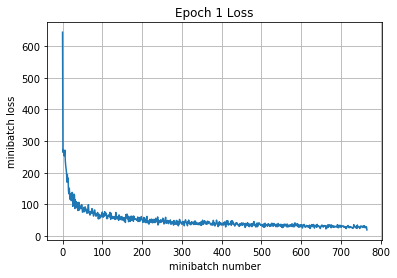

Validation
Epoch 1, Overall loss = 0.435 and accuracy of 0.357


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [6]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    
    """
    setup variables
    """
    # for convolution layer
    Wconv1 = tf.get_variable("Wconv1", shape=[7,7,3,32]) # filter_size,filter_size,C,F
    bconv1 = tf.get_variable("bconv1", shape=[32]) # filter_size
    # for Batch Normalization
    gamma = tf.get_variable("gamma", shape=[32])
    beta = tf.get_variable("beta", shape=[32])
    # for FC layer1
    W1 = tf.get_variable("W1", shape=[13*13*32,1024])
    b1 = tf.get_variable("b1", shape=[1024])
    # for FC layer2
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10])
    
    """
     define graph
    """
    # convolution (N,W,H,C)
    cv = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID')+bconv1
    # relu
    relu1 = tf.nn.relu(cv)
    # Spatial Batch Norm layer
    sample_mean, sample_var = tf.nn.moments(cv, [0], keep_dims=False)
    batch = tf.nn.batch_normalization(relu1, sample_mean,sample_var , beta, gamma, 1e-5)
    # 2x2 Max pooling
    maxPool = tf.nn.max_pool(batch, [1,2,2,1], [1,2,2,1], padding='VALID')
    # Affine1 with 1024 output
    flat = tf.reshape(maxPool, [-1, 13*13*32])
    affine1 = tf.matmul(flat,W1)+b1
    # Relu
    relu2 = tf.nn.relu(affine1)
    # Affine2 with output 10
    y_out = tf.matmul(relu2, W2)+b2
    return y_out
y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [7]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

10 loops, best of 3: 35.3 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [8]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

no gpu found, please use Google Cloud if you want GPU acceleration


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [55]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None

optimizer = tf.train.RMSPropOptimizer(1e-3)
total_loss = tf.losses.softmax_cross_entropy(logits =y_out,onehot_labels=tf.one_hot(y,10))
mean_loss =  tf.reduce_mean(total_loss)
train_step = optimizer.minimize(mean_loss)

In [56]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [57]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.34 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.36 and accuracy of 0.14
Iteration 200: with minibatch training loss = 1.64 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.6 and accuracy of 0.41
Iteration 400: with minibatch training loss = 1.5 and accuracy of 0.48
Iteration 500: with minibatch training loss = 1.32 and accuracy of 0.53
Iteration 600: with minibatch training loss = 1.23 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.41 and accuracy of 0.39
Epoch 1, Overall loss = 1.64 and accuracy of 0.404


(1.6408063148965641, 0.40400000000000003)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [58]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.28 and accuracy of 0.545


(1.2828521718978882, 0.54500000000000004)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [142]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    conv_N = 3
    window_size = 32
    conv_output_dimension = 32
    affine_output = 1024
    num_classes = 10
    # x,shape = [N,W,H,C]
    """
    setup variables
    """
    ##############################################################
    #  1x1 conv - batchnorm
    ##############################################################
    # 1x1 conv
    W1conv1 = tf.get_variable("W1conv1", shape=[1,1,3,conv_output_dimension]) 
    b1conv1 = tf.get_variable("b1conv1", shape=[conv_output_dimension]) # F
    # for Batch Normalization
    gamma1 = tf.get_variable("gamma1", shape=[conv_output_dimension])
    beta1 = tf.get_variable("beta1", shape=[conv_output_dimension])
    ##############################################################
    # 3x3 conv - 3x3 conv - 3x3 conv -  1x1 conv - batchnorm - relu - pool
    ##############################################################
    # 3x3 conv1
    W3conv1 = tf.get_variable("W3conv1", shape=[3,3,conv_output_dimension,16]) 
    b3conv1 = tf.get_variable("b3conv1", shape=[16])
    # 3x3 conv2 (5x5)
    W3conv2 = tf.get_variable("W3conv2", shape=[3,3,16,16]) 
    b3conv2 = tf.get_variable("b3conv2", shape=[16])
    # 3x3 conv3 (7x7)
    W3conv3 = tf.get_variable("W3conv3", shape=[3,3,16,16]) 
    b3conv3 = tf.get_variable("b3conv3", shape=[16]) 
    # 1x1 conv
    W1conv2 = tf.get_variable("W1conv2", shape=[1,1,16,conv_output_dimension]) 
    b1conv2 = tf.get_variable("b1conv2", shape=[conv_output_dimension]) # F
    # for Batch Normalization
    gamma2 = tf.get_variable("gamma2", shape=[conv_output_dimension])
    beta2 = tf.get_variable("beta2", shape=[conv_output_dimension])
    ##############################################################
    #  1x1 conv, 1x1 conv, average pool
    ##############################################################
   # 1x1 conv
    W1conv3 = tf.get_variable("W1conv3", shape=[1,1,conv_output_dimension,conv_output_dimension]) 
    b1conv3 = tf.get_variable("b1conv3", shape=[conv_output_dimension]) # F
    # 1x1 conv
    W1conv4 = tf.get_variable("W1conv4", shape=[1,1,conv_output_dimension,num_classes]) 
    b1conv4= tf.get_variable("b1conv4", shape=[num_classes]) # F
    
    """
     define graph
    """
    out = X
    ##############################################################
    #  1x1 conv - batchnorm
    ##############################################################
    # 1x1 conv
    out = tf.nn.conv2d(out, W1conv1, strides=[1,1,1,1], padding='VALID', name="one_1")+b1conv1    
    # Spatial Batch Norm layer
    sample_mean, sample_var = tf.nn.moments(out, [0], keep_dims=False)
    out = tf.nn.batch_normalization(out, sample_mean,sample_var , beta1, gamma1, 1e-5)
    ##############################################################
    # 3x3 conv - 3x3 conv - 3x3 conv -  1x1 conv - batchnorm - relu
    ##############################################################
    for n in range(conv_N):
        # 3x3 conv
        out = tf.nn.conv2d(out, W3conv1, strides = [1,1,1,1], padding='SAME',name="three_1")+b3conv1
        out = tf.nn.conv2d(out, W3conv2, strides = [1,1,1,1], padding='SAME',name="three_2")+b3conv2
        out = tf.nn.conv2d(out, W3conv3, strides = [1,1,1,1], padding='SAME',name="three_3")+b3conv3
        # 1x1 conv
        out = tf.nn.conv2d(out, W1conv2, strides=[1,1,1,1], padding='VALID', name="one_2")+b1conv2
        # Spatial Batch Norm layer
#         sample_mean, sample_var = tf.nn.moments(out, [0], keep_dims=False)
#         out = tf.nn.batch_normalization(out, sample_mean,sample_var , beta2, gamma2, 1e-5)
        # ReLU
        out = tf.nn.relu(out)
    
    ##############################################################
    #  1x1 conv, 1x1 conv, average pool
    ##############################################################
    # 1x1 conv
    out = tf.nn.conv2d(out, W1conv3, strides=[1,1,1,1], padding='VALID', name="one_3")+b1conv3
    # 1x1 conv
    out = tf.nn.conv2d(out, W1conv4, strides=[1,1,1,1], padding='VALID', name="one_4")+b1conv4
    print(out.shape)
    # average pooling
    out = tf.nn.avg_pool(out,[1,32,32,1],[1,1,1,1],padding='VALID' )
    y_out = tf.reshape(out,[-1,num_classes])
    print (y_out.shape)
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None

optimizer = tf.train.AdamOptimizer(1e-3)
total_loss = tf.losses.softmax_cross_entropy(logits =y_out,onehot_labels=tf.one_hot(y,10))
mean_loss =  tf.reduce_mean(total_loss)
train_step = optimizer.minimize(mean_loss)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 32, 32, 10)
(?, 10)


In [143]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 2.38 and accuracy of 0.047


KeyboardInterrupt: 

In [111]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 1.14 and accuracy of 0.589
Validation
Epoch 1, Overall loss = 1.21 and accuracy of 0.556


(1.2145904598236084, 0.55600000000000005)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [110]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.16 and accuracy of 0.584


(1.1557104972839356, 0.5837)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

In [6]:
"""
                                                     1x1 conv
max pool(2x2, stride :2) - [module : 3x3 conv - relu] x N - FC x2  - softmax
    for reduction window                   5x5 conv
                                                     max pool

"""
import time


def inception_model1(X,y,is_training):
    module_iter = 10
    affine_output = 1024
    num_classes = 10
    MO = 64 # module output/4
    [N,W,H,C] = X.shape
    """
    setup variables
    """
    # 1x1 conv
    W1conv0 = tf.get_variable("W1conv0", shape=[1,1,C,MO])
    b1conv0 = tf.get_variable("b1conv0",shape=[MO])
    ##############################################################
    #
    # inception module v1
    #    
    # layer | 1x1 conv + 3x3 conv + 5x5 conv + max pool
    #   C    |      4             4               4               4         = 16
    ##############################################################
    # 1x1 conv
    W1conv = [tf.get_variable("W1conv"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b1conv = [tf.get_variable("b1conv"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]
    # 3x3 conv 
    W3conv = [tf.get_variable("W3conv"+str(i), shape=[3,3,MO,MO/4]) for i in range(1,module_iter+1)] 
    b3conv = [tf.get_variable("b3conv"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 
    # 5x5 conv
    W5conv = [tf.get_variable("W5conv"+str(i), shape=[5,5,MO,MO/4]) for i in range(1,module_iter+1)]  
    b5conv = [tf.get_variable("b5conv"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 

    W1conv1 = [tf.get_variable("W1conv1"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b1conv1 = [tf.get_variable("b1conv1"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]

    ##############################################################
    #
    #  Fully connected (affine x2)
    #
    ##############################################################
   # affine 1
    W1 = tf.get_variable("W1", shape=[MO/4*int(W*H), affine_output]) 
    b1 = tf.get_variable("b1", shape=[affine_output]) # F
    # affine 2
    W2 = tf.get_variable("W2", shape=[affine_output,num_classes]) 
    b2= tf.get_variable("b2", shape=[num_classes]) # F
    
    """
     define graph
    """
    out = X
    ##############################################################
    #
    #  1. max pool (2x2) stride = 2
    #
    #  To reduce window size
    #
    #  INPUT : [N,W,H,C]
    # OUTPUT : [N,W/2,H/2,C]  
    ##############################################################
    
    out = tf.nn.max_pool(out, [1,2,2,1], [1,2,2,1], padding='VALID')
    out = tf.nn.conv2d(out, W1conv0, strides=[1,1,1,1], padding='VALID', name='init')+b1conv0
    ##############################################################
    #
    #  2. inception_moduel
    #
    #  Concatenate result of 1x1 conv, 3x3conv, 5x5 conv, max pool  
    #
    #  INPUT : [N,W/2,H/2,C]
    #  OUTPUT : [N,W/2, H/2, C]
    #
    ##############################################################
    for i in range(module_iter):

        out1 = tf.nn.conv2d(out, W1conv[i], strides=[1,1,1,1], padding='VALID', name="one")+b1conv[i]    

        out3 = tf.nn.conv2d(out, W3conv[i], strides = [1,1,1,1], padding='SAME',name="three")+b3conv[i]

        out5 = tf.nn.conv2d(out, W5conv[i], strides = [1,1,1,1], padding='SAME',name="five")+b5conv[i]

        out_max = tf.nn.conv2d(out, W1conv1[i], strides=[1,1,1,1], padding='SAME',name="one1")+b1conv1[i]
        out_max = tf.nn.max_pool(out_max, [1,3,3,1], [1,1,1,1], padding='SAME',name="max")

        out = tf.concat([out1, out3, out5, out_max], 3)
        out = tf.nn.relu(out)
    ##############################################################
    # 
    #  3. Fully Connected
    #
    #  INPUT : [N,W/2,H/2,C]
    #  OUTPUT : [#Class]
    ##############################################################
    out = tf.reshape(out,[-1, int(MO/4)*int(W*H)])
    out = tf.matmul(out,W1)+b1
    y_out = tf.matmul(out,W2)+b2
    return y_out

def inception_model2(X,y,is_training):
    module_iter = 10
    affine_output = 1024
    num_classes = 10
    MO = 64 # module output/4
    [N,W,H,C] = X.shape
    """
    setup variables
    """
    # 1x1 conv
    W1conv0 = tf.get_variable("W1conv0", shape=[1,1,C,MO])
    b1conv0 = tf.get_variable("b1conv0",shape=[MO])
    ##############################################################
    #
    # inception module v1
    #    
    # layer | 1x1 conv + (3x3 conv) + [3x3 conv - 3x3 conv] + max pool
    #   C    |      4             4               4               4         = 16
    ##############################################################
    # 1x1 conv
    W1conv = [tf.get_variable("W1conv"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b1conv = [tf.get_variable("b1conv"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]
    # 3x3 conv 
    W3conv = [tf.get_variable("W3conv"+str(i), shape=[3,3,MO,MO/4]) for i in range(1,module_iter+1)] 
    b3conv = [tf.get_variable("b3conv"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 
    # 3x3 conv
    W5conv1 = [tf.get_variable("W5conv1"+str(i), shape=[3,3,MO,MO/4]) for i in range(1,module_iter+1)]  
    b5conv1 = [tf.get_variable("b5conv1"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 
    W5conv2 = [tf.get_variable("W5conv2"+str(i), shape=[3,3,MO/4,MO/4]) for i in range(1,module_iter+1)]  
    b5conv2 = [tf.get_variable("b5conv2"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 

    W1conv1 = [tf.get_variable("W1conv1"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b1conv1 = [tf.get_variable("b1conv1"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]
    ##############################################################
    #
    #  Fully connected (affine x2)
    #
    ##############################################################
   # affine 1
    W1 = tf.get_variable("W1", shape=[MO/4*int(W*H), affine_output]) 
    b1 = tf.get_variable("b1", shape=[affine_output]) # F
    # affine 2
    W2 = tf.get_variable("W2", shape=[affine_output,num_classes]) 
    b2= tf.get_variable("b2", shape=[num_classes]) # F
    
    """
     define graph
    """
    out = X
    ##############################################################
    #
    #  1. max pool (2x2) stride = 2
    #
    #  To reduce window size
    #
    #  INPUT : [N,W,H,C]
    # OUTPUT : [N,W/2,H/2,C]  
    ##############################################################
    
    out = tf.nn.max_pool(out, [1,2,2,1], [1,2,2,1], padding='VALID')
    out = tf.nn.conv2d(out, W1conv0, strides=[1,1,1,1], padding='VALID', name='init')+b1conv0
    ##############################################################
    #
    #  2. inception_moduel
    #
    #  Concatenate result of 1x1 conv, 3x3conv, 5x5 conv, max pool  
    #
    #  INPUT : [N,W/2,H/2,C]
    #  OUTPUT : [N,W/2, H/2, C]
    #
    ##############################################################
    for i in range(module_iter):
        out1 = tf.nn.conv2d(out, W1conv[i], strides=[1,1,1,1], padding='VALID', name="one")+b1conv[i]    
        out3 = tf.nn.conv2d(out, W3conv[i], strides = [1,1,1,1], padding='SAME',name="three")+b3conv[i]
        out5 = tf.nn.conv2d(out, W5conv1[i], strides = [1,1,1,1], padding='SAME',name="five1")+b5conv1[i]
        out5 = tf.nn.conv2d(out5, W5conv2[i], strides = [1,1,1,1], padding='SAME',name="five2")+b5conv2[i]
        out_max = tf.nn.conv2d(out, W1conv1[i], strides=[1,1,1,1], padding='SAME',name="one1")+b1conv1[i]
        out_max = tf.nn.max_pool(out_max, [1,3,3,1], [1,1,1,1], padding='SAME',name="max")
        out = tf.concat([out1, out3, out5, out_max], 3)
        out = tf.nn.relu(out)
    ##############################################################
    # 
    #  3. Fully Connected
    #
    #  INPUT : [N,W/2,H/2,C]
    #  OUTPUT : [#Class]
    ##############################################################
    out = tf.reshape(out,[-1, int(MO/4)*int(W*H)])
    out = tf.matmul(out,W1)+b1
    y_out = tf.matmul(out,W2)+b2
    return y_out

def inception_model3(X,y,is_training):
    module_iter = 10
    affine_output = 1024
    num_classes = 10
    MO = 64 # module output/4
    [N,W,H,C] = X.shape
    """
    setup variables
    """
    # 1x1 conv
    W1conv0 = tf.get_variable("W1conv0", shape=[1,1,C,MO])
    b1conv0 = tf.get_variable("b1conv0",shape=[MO])
    ##############################################################
    #
    # inception module v3
    #    
    # layer | 1x1 conv + (1x1conv-3x3 conv) + [1x1-conv-3x3 conv - 3x3 conv] + [max pool-1x1 conv]
    #   C    |      4             4               4               4         = 16
    ##############################################################
    # 1x1 conv
    W1conv1 = [tf.get_variable("W1conv"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b1conv1 = [tf.get_variable("b1conv"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]
    # 3x3 conv 
    W3conv1= [tf.get_variable("W3conv1"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b3conv1 = [tf.get_variable("b3conv1"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]
    W3conv2 = [tf.get_variable("W3conv2"+str(i), shape=[3,3,MO/4,MO/4]) for i in range(1,module_iter+1)] 
    b3conv2 = [tf.get_variable("b3conv2"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 
    # 5x5 conv
    W5conv1= [tf.get_variable("W5conv1"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b5conv1 = [tf.get_variable("b5conv1"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]
    W5conv2 = [tf.get_variable("W5conv2"+str(i), shape=[3,3,MO/4,MO/4]) for i in range(1,module_iter+1)]  
    b5conv2 = [tf.get_variable("b5conv2"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 
    W5conv3 = [tf.get_variable("W5conv3"+str(i), shape=[3,3,MO/4,MO/4]) for i in range(1,module_iter+1)]  
    b5conv3 = [tf.get_variable("b5conv3"+str(i), shape=[MO/4]) for i in range(1,module_iter+1)] 
    # max pool
    W1conv2 = [tf.get_variable("W1conv2"+str(i), shape=[1,1,MO,MO/4]) for i in range(1,module_iter+1)] 
    b1conv2 = [tf.get_variable("b1conv2"+str(i), shape=[MO/4] )for i in range(1,module_iter+1)]
    ##############################################################
    #
    #  Fully connected (affine x2)
    #
    ##############################################################
   # affine 1
    W1 = tf.get_variable("W1", shape=[int(MO/4)*int(W*H), affine_output]) 
    b1 = tf.get_variable("b1", shape=[affine_output]) # F
    # affine 2
    W2 = tf.get_variable("W2", shape=[affine_output,num_classes]) 
    b2= tf.get_variable("b2", shape=[num_classes]) # F
    
    """
     define graph
    """
    out = X
    ##############################################################
    #
    #  1. max pool (2x2) stride = 2
    #
    #  To reduce window size
    #
    #  INPUT : [N,W,H,C]
    # OUTPUT : [N,W/2,H/2,C]  
    ##############################################################
    out = tf.nn.max_pool(out, [1,2,2,1], [1,2,2,1], padding='VALID')
    out = tf.nn.conv2d(out, W1conv0, strides=[1,1,1,1], padding='VALID', name='init')+b1conv0
    ##############################################################
    #
    #  2. inception_moduel
    #
    #  Concatenate result of 1x1 conv, 3x3conv, 5x5 conv, max pool  
    #
    #  INPUT : [N,W/2,H/2,C]
    #  OUTPUT : [N,W/2, H/2, C]
    #
    ##############################################################
    for i in range(module_iter):
        # 1x1 conv
        out1 = tf.nn.conv2d(out, W1conv1[i], strides=[1,1,1,1], padding='VALID', name="one")+b1conv1[i]    
        # 3x3 conv
        out3 = tf.nn.conv2d(out,W3conv1[i],strides=[1,1,1,1], padding='SAME', name = "three1")+b3conv1[i]
        out3 = tf.nn.conv2d(out3, W3conv2[i], strides = [1,1,1,1], padding='SAME',name="three2")+b3conv2[i]
        # 5x5 conv
        out5 = tf.nn.conv2d(out, W5conv1[i], strides=[1,1,1,1], padding='SAME', name="five1")+b5conv1[i]
        out5 = tf.nn.conv2d(out5, W5conv2[i], strides = [1,1,1,1], padding='SAME',name="five2")+b5conv2[i]
        out5 = tf.nn.conv2d(out5, W5conv3[i], strides = [1,1,1,1], padding='SAME',name="five3")+b5conv3[i]
        # max
        out_max = tf.nn.max_pool(out, [1,3,3,1], [1,1,1,1], padding='SAME',name="max1")
        out_max = tf.nn.conv2d(out_max, W1conv2[i], strides=[1,1,1,1], padding='SAME', name="max2")+b1conv2[i]
        out = tf.concat([out1, out3, out5, out_max], 3)
        out = tf.nn.relu(out)
    ##############################################################
    # 
    #  3. Fully Connected
    #
    #  INPUT : [N,W/2,H/2,C]
    #  OUTPUT : [#Class]
    ##############################################################
    out = tf.reshape(out,[-1,int(MO/4)*int(W*H)])
    out = tf.matmul(out,W1)+b1
    y_out = tf.matmul(out,W2)+b2
    return y_out

def NIN(X,y,is_training):
    module_iter = 10
    fully_layer_num = 3
    num_classes = 10
    [N,W,H,C] = X.shape
    """
    setup variables
    """
    # 3x3 conv
    F0 = 64
    W3conv0 = tf.get_variable("W3conv0", shape=[3,3,C,F0])
    b3conv0 = tf.get_variable("b1conv0", shape=[F0])
    ##############################################################
    # Convolution layer 3x3 - [1x1]*FN 
    ##############################################################
    W3conv1 = [tf.get_variable("W3conv1"+str(i), shape=[3,3,F0,F0]) for i in range(1,module_iter+1)] 
    b3conv1 = [tf.get_variable("b3conv1"+str(i), shape=[F0]) for i in range(1,module_iter+1)] 
    W1conv1= [[tf.get_variable("W1conv1"+str(i)+"_"+str(f), shape=[1,1,F0,F0])  for f in range(fully_layer_num)] for i in range(1,module_iter+1)] 
    b1conv1 = [[tf.get_variable("b1conv1"+str(i)+"_"+str(f), shape=[F0] )for f in range(fully_layer_num)] for i in range(1,module_iter+1)] 
    W1conv1[module_iter-1][fully_layer_num-1]= tf.get_variable("W1conv1"+str(module_iter)+"_"+str(fully_layer_num),shape=[1,1,F0,num_classes]) 
    b1conv1[module_iter-1][fully_layer_num-1] = tf.get_variable("b1conv1"+str(module_iter)+"_"+str(fully_layer_num),shape=[num_classes])
    
    """
     define graph
    """
    out = tf.nn.conv2d(X,W3conv0,strides=[1,1,1,1], padding='SAME', name = "three")+b3conv0   
    for i in range(module_iter):
        out = tf.nn.conv2d(out, W3conv1[i], strides = [1,1,1,1], padding='SAME',name="three1")+b3conv1[i]
        for f in range(fully_layer_num):
            out = tf.nn.conv2d(out,W1conv1[i][f],strides=[1,1,1,1], padding='SAME', name = "one1")+b1conv1[i][f]
    out = tf.nn.avg_pool(out, [1,32,32,1], [1,1,1,1], padding='VALID',name="avg1")
    y_out = tf.reshape(out, [-1, num_classes])
    return y_out


def residual(X,y,is_training):
    module_iter = 10
    num_classes = 10
    [N,W,H,C] = X.shape      
    """
    setup variables
    """
    # 3x3 conv
    F0 = 64
    W3conv0 = tf.get_variable("W3conv0", shape=[5,5,C,F0])
    b3conv0 = tf.get_variable("b1conv0", shape=[F0])
    ##############################################################
    # Convolution layer 3x3 - [1x1]*FN 
    ##############################################################
    W3conv1 = [tf.get_variable("W3conv1"+str(i), shape=[3,3,F0,F0]) for i in range(1,module_iter+1)] 
    b3conv1 = [tf.get_variable("b3conv1"+str(i), shape=[F0]) for i in range(1,module_iter+1)] 
    W1 = tf.get_variable("W1", shape= [32**2*F0, 1000])
    b1 = tf.get_variable("b1", shape=[1000])
    W2 = tf.get_variable("W2", shape= [1000, num_classes])
    b2= tf.get_variable("b2", shape=[num_classes])
    """
     define graph
    """
    out = tf.nn.conv2d(X,W3conv0,strides=[1,1,1,1], padding='SAME', name = "three")+b3conv0   
    for i in range(int(module_iter/2)):
        out_t = tf.nn.conv2d(out, W3conv1[2*i], strides = [1,1,1,1], padding='SAME',name="three1")+b3conv1[2*i]
        out_t = tf.nn.relu(out_t)
        out_t = tf.nn.conv2d(out_t, W3conv1[2*i+1], strides = [1,1,1,1], padding='SAME',name="three1")+b3conv1[2*i+1]
        out = out_t + out
        out = tf.nn.relu(out)
    out = tf.nn.avg_pool(out, [1,3,3,1], [1,1,1,1], padding='SAME',name="avg1")
    out = tf.reshape(out, [-1,32*32*F0])
    out = tf.matmul(out, W1)+b1
    y_out = tf.matmul(out, W2)+b2
    return y_out

                                                
                                                

Training
Iteration 0: with minibatch training loss = 47 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.25 and accuracy of 0.22
Iteration 200: with minibatch training loss = 2.08 and accuracy of 0.3
Iteration 300: with minibatch training loss = 1.79 and accuracy of 0.33
Iteration 400: with minibatch training loss = 1.68 and accuracy of 0.38
Iteration 500: with minibatch training loss = 1.82 and accuracy of 0.31
Iteration 600: with minibatch training loss = 1.67 and accuracy of 0.42
Iteration 700: with minibatch training loss = 1.7 and accuracy of 0.34
Epoch 1, Overall loss = 3.83 and accuracy of 0.327


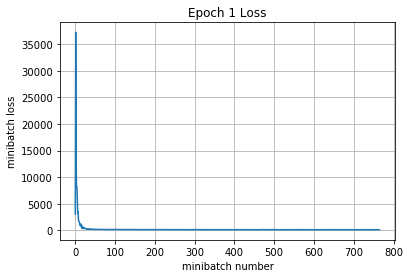

Iteration 800: with minibatch training loss = 1.45 and accuracy of 0.47
Iteration 900: with minibatch training loss = 1.39 and accuracy of 0.48
Iteration 1000: with minibatch training loss = 1.48 and accuracy of 0.39
Iteration 1100: with minibatch training loss = 1.5 and accuracy of 0.45
Iteration 1200: with minibatch training loss = 1.24 and accuracy of 0.58
Iteration 1300: with minibatch training loss = 1.66 and accuracy of 0.41
Iteration 1400: with minibatch training loss = 1.32 and accuracy of 0.55
Iteration 1500: with minibatch training loss = 1.54 and accuracy of 0.33
Epoch 2, Overall loss = 1.53 and accuracy of 0.443


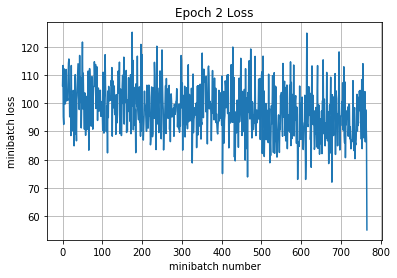

Iteration 1600: with minibatch training loss = 1.8 and accuracy of 0.31
Iteration 1700: with minibatch training loss = 1.51 and accuracy of 0.47
Iteration 1800: with minibatch training loss = 1.6 and accuracy of 0.38
Iteration 1900: with minibatch training loss = 1.63 and accuracy of 0.39
Iteration 2000: with minibatch training loss = 1.59 and accuracy of 0.39
Iteration 2100: with minibatch training loss = 1.37 and accuracy of 0.42
Iteration 2200: with minibatch training loss = 1.57 and accuracy of 0.39
Epoch 3, Overall loss = 1.45 and accuracy of 0.472


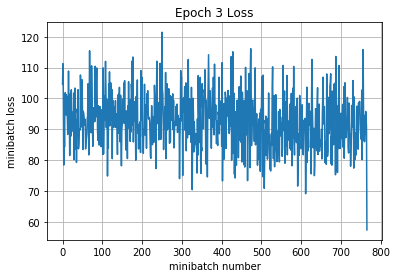

Iteration 2300: with minibatch training loss = 1.45 and accuracy of 0.48
Iteration 2400: with minibatch training loss = 1.64 and accuracy of 0.41
Iteration 2500: with minibatch training loss = 1.31 and accuracy of 0.56
Iteration 2600: with minibatch training loss = 1.1 and accuracy of 0.67
Iteration 2700: with minibatch training loss = 1.04 and accuracy of 0.55
Iteration 2800: with minibatch training loss = 1.22 and accuracy of 0.47
Iteration 2900: with minibatch training loss = 1.64 and accuracy of 0.39
Iteration 3000: with minibatch training loss = 1.58 and accuracy of 0.42
Epoch 4, Overall loss = 1.41 and accuracy of 0.487


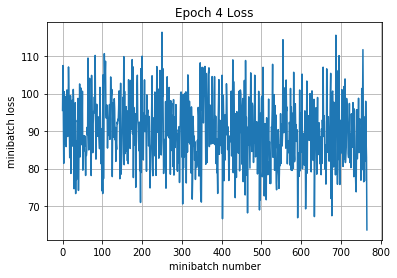

Iteration 3100: with minibatch training loss = 1.14 and accuracy of 0.64
Iteration 3200: with minibatch training loss = 1.25 and accuracy of 0.53
Iteration 3300: with minibatch training loss = 1.44 and accuracy of 0.42
Iteration 3400: with minibatch training loss = 1.49 and accuracy of 0.48
Iteration 3500: with minibatch training loss = 1.33 and accuracy of 0.53
Iteration 3600: with minibatch training loss = 1.32 and accuracy of 0.52
Iteration 3700: with minibatch training loss = 1.44 and accuracy of 0.42
Iteration 3800: with minibatch training loss = 1.24 and accuracy of 0.59
Epoch 5, Overall loss = 1.36 and accuracy of 0.504


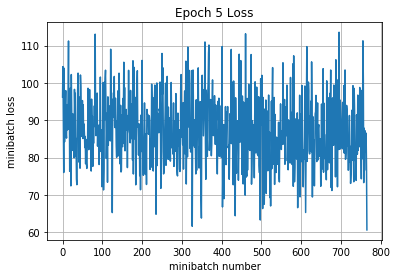

Iteration 3900: with minibatch training loss = 1.44 and accuracy of 0.52
Iteration 4000: with minibatch training loss = 1.33 and accuracy of 0.53
Iteration 4100: with minibatch training loss = 1.29 and accuracy of 0.53
Iteration 4200: with minibatch training loss = 1.39 and accuracy of 0.44
Iteration 4300: with minibatch training loss = 1.43 and accuracy of 0.58
Iteration 4400: with minibatch training loss = 1.41 and accuracy of 0.48
Iteration 4500: with minibatch training loss = 1.28 and accuracy of 0.52
Epoch 6, Overall loss = 1.33 and accuracy of 0.522


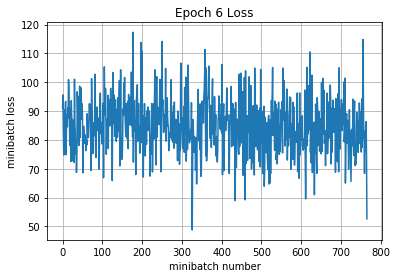

Iteration 4600: with minibatch training loss = 1.46 and accuracy of 0.47
Iteration 4700: with minibatch training loss = 1.24 and accuracy of 0.58
Iteration 4800: with minibatch training loss = 1.29 and accuracy of 0.55
Iteration 4900: with minibatch training loss = 1.35 and accuracy of 0.58
Iteration 5000: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 5100: with minibatch training loss = 1.36 and accuracy of 0.48
Iteration 5200: with minibatch training loss = 1.18 and accuracy of 0.61
Iteration 5300: with minibatch training loss = 1.35 and accuracy of 0.53
Epoch 7, Overall loss = 1.29 and accuracy of 0.534


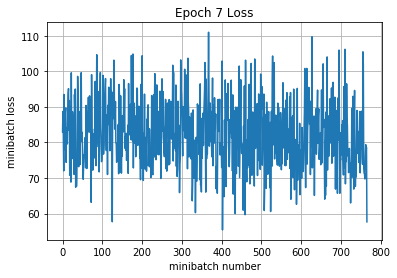

Iteration 5400: with minibatch training loss = 1.36 and accuracy of 0.52
Iteration 5500: with minibatch training loss = 1.15 and accuracy of 0.58
Iteration 5600: with minibatch training loss = 1.25 and accuracy of 0.58
Iteration 5700: with minibatch training loss = 1.09 and accuracy of 0.64
Iteration 5800: with minibatch training loss = 1.37 and accuracy of 0.44
Iteration 5900: with minibatch training loss = 1.15 and accuracy of 0.59
Iteration 6000: with minibatch training loss = 1.21 and accuracy of 0.62
Iteration 6100: with minibatch training loss = 1.18 and accuracy of 0.56
Epoch 8, Overall loss = 1.26 and accuracy of 0.541


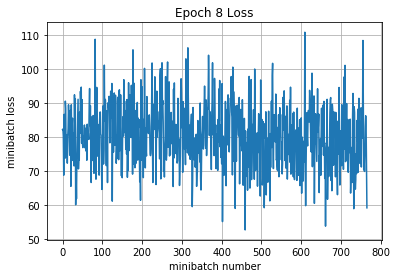

Iteration 6200: with minibatch training loss = 0.969 and accuracy of 0.69
Iteration 6300: with minibatch training loss = 1.31 and accuracy of 0.53
Iteration 6400: with minibatch training loss = 1.31 and accuracy of 0.48
Iteration 6500: with minibatch training loss = 1.28 and accuracy of 0.5
Iteration 6600: with minibatch training loss = 1.17 and accuracy of 0.55
Iteration 6700: with minibatch training loss = 0.989 and accuracy of 0.66
Iteration 6800: with minibatch training loss = 1.42 and accuracy of 0.56
Epoch 9, Overall loss = 1.21 and accuracy of 0.565


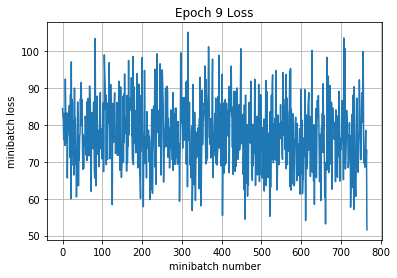

Iteration 6900: with minibatch training loss = 1.15 and accuracy of 0.56
Iteration 7000: with minibatch training loss = 1.24 and accuracy of 0.56
Iteration 7100: with minibatch training loss = 1.33 and accuracy of 0.47
Iteration 7200: with minibatch training loss = 1.15 and accuracy of 0.59
Iteration 7300: with minibatch training loss = 1.02 and accuracy of 0.64
Iteration 7400: with minibatch training loss = 1.24 and accuracy of 0.48
Iteration 7500: with minibatch training loss = 1.19 and accuracy of 0.55
Iteration 7600: with minibatch training loss = 1.06 and accuracy of 0.62
Epoch 10, Overall loss = 1.18 and accuracy of 0.577


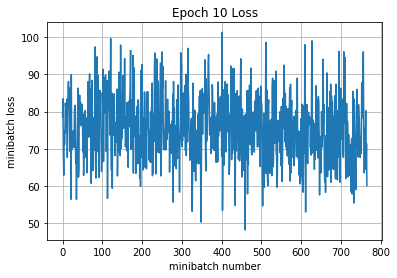

12646.615140199661
Validation
Epoch 1, Overall loss = 1.15 and accuracy of 0.586
Training
Epoch 1, Overall loss = 1.12 and accuracy of 0.596
Validation
Epoch 1, Overall loss = 1.15 and accuracy of 0.586
Test
Epoch 1, Overall loss = 1.21 and accuracy of 0.565


(1.2068597509384156, 0.56469999999999998)

In [76]:
###################################################################################
#      inception model v1 test
###################################################################################

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = inception_model1(X,y,is_training)
optimizer = tf.train.AdamOptimizer(1e-3)
total_loss = tf.losses.softmax_cross_entropy(logits =y_out,onehot_labels=tf.one_hot(y,10))
mean_loss =  tf.reduce_mean(total_loss)
train_step = optimizer.minimize(mean_loss)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())
start_time = time.time()
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
end_time = time.time()
print (end_time-start_time)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Training
Iteration 0: with minibatch training loss = 29.1 and accuracy of 0.19
Iteration 100: with minibatch training loss = 2.13 and accuracy of 0.2
Iteration 200: with minibatch training loss = 1.76 and accuracy of 0.34
Iteration 300: with minibatch training loss = 1.51 and accuracy of 0.42
Iteration 400: with minibatch training loss = 1.66 and accuracy of 0.38
Iteration 500: with minibatch training loss = 1.51 and accuracy of 0.53
Iteration 600: with minibatch training loss = 1.54 and accuracy of 0.53
Iteration 700: with minibatch training loss = 1.69 and accuracy of 0.41
Epoch 1, Overall loss = 3.17 and accuracy of 0.36


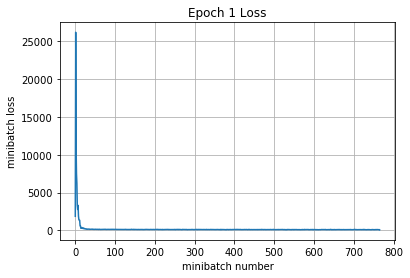

Iteration 800: with minibatch training loss = 1.48 and accuracy of 0.48
Iteration 900: with minibatch training loss = 1.45 and accuracy of 0.44
Iteration 1000: with minibatch training loss = 1.44 and accuracy of 0.5
Iteration 1100: with minibatch training loss = 1.57 and accuracy of 0.48
Iteration 1200: with minibatch training loss = 1.46 and accuracy of 0.47
Iteration 1300: with minibatch training loss = 1.49 and accuracy of 0.42
Iteration 1400: with minibatch training loss = 1.53 and accuracy of 0.42
Iteration 1500: with minibatch training loss = 1.65 and accuracy of 0.41
Epoch 2, Overall loss = 1.48 and accuracy of 0.464


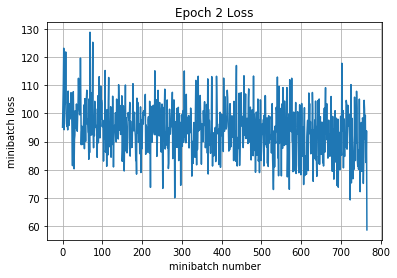

Iteration 1600: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 1700: with minibatch training loss = 1.41 and accuracy of 0.45
Iteration 1800: with minibatch training loss = 1.24 and accuracy of 0.52
Iteration 1900: with minibatch training loss = 1.43 and accuracy of 0.52
Iteration 2000: with minibatch training loss = 1.64 and accuracy of 0.36
Iteration 2100: with minibatch training loss = 1.42 and accuracy of 0.58
Iteration 2200: with minibatch training loss = 1.33 and accuracy of 0.53
Epoch 3, Overall loss = 1.39 and accuracy of 0.501


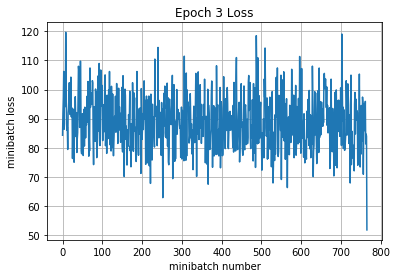

Iteration 2300: with minibatch training loss = 1.32 and accuracy of 0.55
Iteration 2400: with minibatch training loss = 1.25 and accuracy of 0.56
Iteration 2500: with minibatch training loss = 1.47 and accuracy of 0.38
Iteration 2600: with minibatch training loss = 1.27 and accuracy of 0.47
Iteration 2700: with minibatch training loss = 1.16 and accuracy of 0.62
Iteration 2800: with minibatch training loss = 1.26 and accuracy of 0.5
Iteration 2900: with minibatch training loss = 1.44 and accuracy of 0.44
Iteration 3000: with minibatch training loss = 1.7 and accuracy of 0.44
Epoch 4, Overall loss = 1.32 and accuracy of 0.523


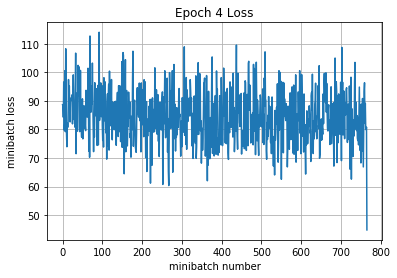

Iteration 3100: with minibatch training loss = 1.31 and accuracy of 0.48
Iteration 3200: with minibatch training loss = 1.24 and accuracy of 0.56
Iteration 3300: with minibatch training loss = 1.39 and accuracy of 0.52
Iteration 3400: with minibatch training loss = 1.17 and accuracy of 0.59
Iteration 3500: with minibatch training loss = 1.47 and accuracy of 0.44
Iteration 3600: with minibatch training loss = 1.18 and accuracy of 0.58
Iteration 3700: with minibatch training loss = 1.4 and accuracy of 0.5
Iteration 3800: with minibatch training loss = 1.2 and accuracy of 0.53
Epoch 5, Overall loss = 1.27 and accuracy of 0.542


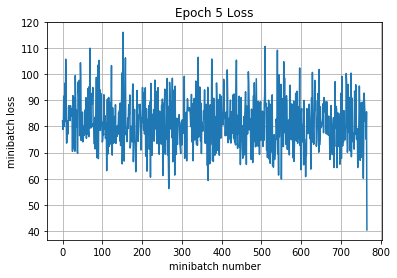

Iteration 3900: with minibatch training loss = 1.46 and accuracy of 0.53
Iteration 4000: with minibatch training loss = 1.17 and accuracy of 0.55
Iteration 4100: with minibatch training loss = 1.35 and accuracy of 0.41
Iteration 4200: with minibatch training loss = 0.993 and accuracy of 0.67
Iteration 4300: with minibatch training loss = 1.35 and accuracy of 0.56
Iteration 4400: with minibatch training loss = 0.982 and accuracy of 0.66
Iteration 4500: with minibatch training loss = 1.18 and accuracy of 0.59
Epoch 6, Overall loss = 1.23 and accuracy of 0.557


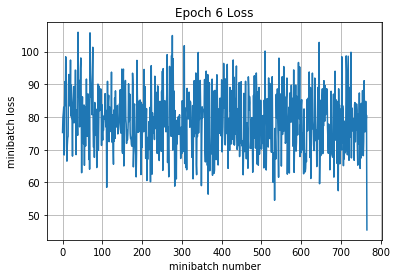

Iteration 4600: with minibatch training loss = 1 and accuracy of 0.61
Iteration 4700: with minibatch training loss = 1.34 and accuracy of 0.5
Iteration 4800: with minibatch training loss = 1.15 and accuracy of 0.64
Iteration 4900: with minibatch training loss = 1.24 and accuracy of 0.58
Iteration 5000: with minibatch training loss = 1.27 and accuracy of 0.61
Iteration 5100: with minibatch training loss = 1.24 and accuracy of 0.58
Iteration 5200: with minibatch training loss = 1.21 and accuracy of 0.62
Iteration 5300: with minibatch training loss = 1.19 and accuracy of 0.58
Epoch 7, Overall loss = 1.19 and accuracy of 0.575


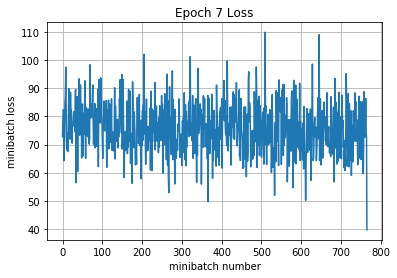

Iteration 5400: with minibatch training loss = 0.893 and accuracy of 0.64
Iteration 5500: with minibatch training loss = 1.19 and accuracy of 0.56
Iteration 5600: with minibatch training loss = 1.09 and accuracy of 0.61
Iteration 5700: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 5800: with minibatch training loss = 1.24 and accuracy of 0.62
Iteration 5900: with minibatch training loss = 1.12 and accuracy of 0.53
Iteration 6000: with minibatch training loss = 0.962 and accuracy of 0.62
Iteration 6100: with minibatch training loss = 1.2 and accuracy of 0.53
Epoch 8, Overall loss = 1.15 and accuracy of 0.589


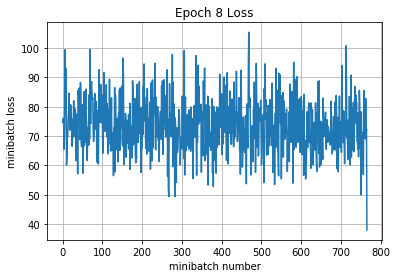

Iteration 6200: with minibatch training loss = 1.28 and accuracy of 0.55
Iteration 6300: with minibatch training loss = 0.949 and accuracy of 0.67
Iteration 6400: with minibatch training loss = 1.21 and accuracy of 0.59
Iteration 6500: with minibatch training loss = 0.959 and accuracy of 0.64
Iteration 6600: with minibatch training loss = 1.08 and accuracy of 0.55
Iteration 6700: with minibatch training loss = 1.33 and accuracy of 0.5
Iteration 6800: with minibatch training loss = 0.957 and accuracy of 0.59
Epoch 9, Overall loss = 1.12 and accuracy of 0.599


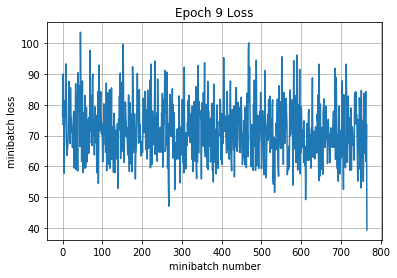

Iteration 6900: with minibatch training loss = 1.38 and accuracy of 0.47
Iteration 7000: with minibatch training loss = 1.06 and accuracy of 0.64
Iteration 7100: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 7200: with minibatch training loss = 1.46 and accuracy of 0.59
Iteration 7300: with minibatch training loss = 1.24 and accuracy of 0.59
Iteration 7400: with minibatch training loss = 0.953 and accuracy of 0.61
Iteration 7500: with minibatch training loss = 0.831 and accuracy of 0.66
Iteration 7600: with minibatch training loss = 0.822 and accuracy of 0.72
Epoch 10, Overall loss = 1.09 and accuracy of 0.61


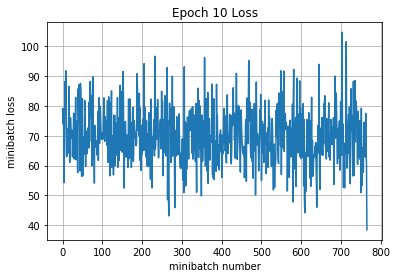

7791.720436096191
Validation
Epoch 1, Overall loss = 1.18 and accuracy of 0.579
Training
Epoch 1, Overall loss = 1.06 and accuracy of 0.628
Validation
Epoch 1, Overall loss = 1.18 and accuracy of 0.579
Test
Epoch 1, Overall loss = 1.18 and accuracy of 0.587


(1.1822072303771973, 0.58709999999999996)

In [77]:
###################################################################################
#      inception model v2 test
###################################################################################

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = inception_model2(X,y,is_training)
optimizer = tf.train.AdamOptimizer(1e-3)
total_loss = tf.losses.softmax_cross_entropy(logits =y_out,onehot_labels=tf.one_hot(y,10))
mean_loss =  tf.reduce_mean(total_loss)
train_step = optimizer.minimize(mean_loss)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())
start_time = time.time()
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
end_time = time.time()
print (end_time-start_time)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Training
Iteration 0: with minibatch training loss = 37.8 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.2 and accuracy of 0.17
Iteration 200: with minibatch training loss = 1.81 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.69 and accuracy of 0.38
Iteration 400: with minibatch training loss = 1.76 and accuracy of 0.31
Iteration 500: with minibatch training loss = 1.71 and accuracy of 0.39
Iteration 600: with minibatch training loss = 1.37 and accuracy of 0.47
Iteration 700: with minibatch training loss = 1.56 and accuracy of 0.45
Epoch 1, Overall loss = 4.02 and accuracy of 0.352


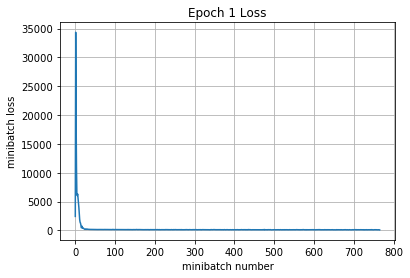

Iteration 800: with minibatch training loss = 1.62 and accuracy of 0.39
Iteration 900: with minibatch training loss = 1.49 and accuracy of 0.47
Iteration 1000: with minibatch training loss = 1.54 and accuracy of 0.45
Iteration 1100: with minibatch training loss = 1.57 and accuracy of 0.47
Iteration 1200: with minibatch training loss = 1.53 and accuracy of 0.56
Iteration 1300: with minibatch training loss = 1.33 and accuracy of 0.52
Iteration 1400: with minibatch training loss = 1.49 and accuracy of 0.5
Iteration 1500: with minibatch training loss = 1.15 and accuracy of 0.58
Epoch 2, Overall loss = 1.5 and accuracy of 0.457


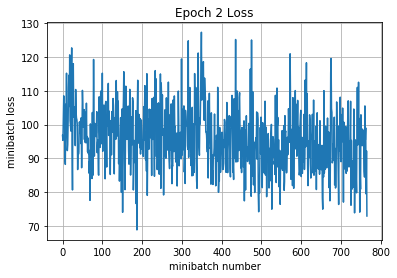

Iteration 1600: with minibatch training loss = 1.28 and accuracy of 0.47
Iteration 1700: with minibatch training loss = 1.32 and accuracy of 0.56
Iteration 1800: with minibatch training loss = 1.32 and accuracy of 0.42
Iteration 1900: with minibatch training loss = 1.5 and accuracy of 0.45
Iteration 2000: with minibatch training loss = 1.43 and accuracy of 0.47
Iteration 2100: with minibatch training loss = 1.59 and accuracy of 0.44
Iteration 2200: with minibatch training loss = 1.51 and accuracy of 0.47
Epoch 3, Overall loss = 1.39 and accuracy of 0.497


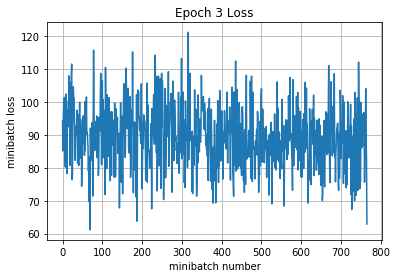

Iteration 2300: with minibatch training loss = 1.5 and accuracy of 0.42
Iteration 2400: with minibatch training loss = 1.46 and accuracy of 0.44
Iteration 2500: with minibatch training loss = 1.3 and accuracy of 0.56
Iteration 2600: with minibatch training loss = 1.31 and accuracy of 0.48
Iteration 2700: with minibatch training loss = 1.29 and accuracy of 0.58
Iteration 2800: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 2900: with minibatch training loss = 1.1 and accuracy of 0.66
Iteration 3000: with minibatch training loss = 1.29 and accuracy of 0.5
Epoch 4, Overall loss = 1.33 and accuracy of 0.523


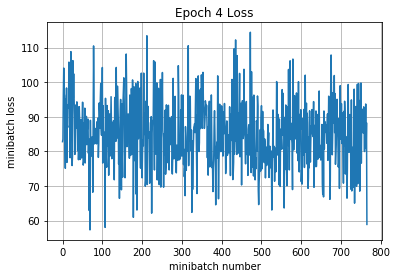

Iteration 3100: with minibatch training loss = 1.33 and accuracy of 0.52
Iteration 3200: with minibatch training loss = 1.31 and accuracy of 0.53
Iteration 3300: with minibatch training loss = 1.42 and accuracy of 0.52
Iteration 3400: with minibatch training loss = 1.34 and accuracy of 0.52
Iteration 3500: with minibatch training loss = 1.33 and accuracy of 0.55
Iteration 3600: with minibatch training loss = 1.29 and accuracy of 0.59
Iteration 3700: with minibatch training loss = 1.32 and accuracy of 0.56
Iteration 3800: with minibatch training loss = 1.31 and accuracy of 0.48
Epoch 5, Overall loss = 1.27 and accuracy of 0.545


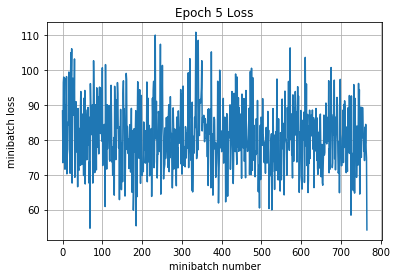

Iteration 3900: with minibatch training loss = 1.26 and accuracy of 0.55
Iteration 4000: with minibatch training loss = 1.27 and accuracy of 0.53
Iteration 4100: with minibatch training loss = 1.13 and accuracy of 0.59
Iteration 4200: with minibatch training loss = 1.21 and accuracy of 0.53
Iteration 4300: with minibatch training loss = 1.1 and accuracy of 0.69
Iteration 4400: with minibatch training loss = 1.16 and accuracy of 0.58
Iteration 4500: with minibatch training loss = 1.06 and accuracy of 0.53
Epoch 6, Overall loss = 1.23 and accuracy of 0.561


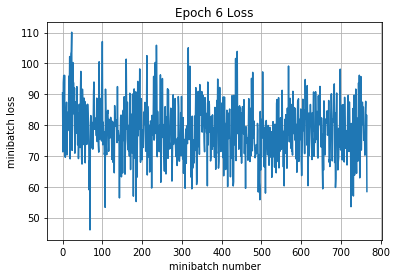

Iteration 4600: with minibatch training loss = 1.27 and accuracy of 0.56
Iteration 4700: with minibatch training loss = 1.25 and accuracy of 0.55
Iteration 4800: with minibatch training loss = 1.38 and accuracy of 0.5
Iteration 4900: with minibatch training loss = 1.08 and accuracy of 0.59
Iteration 5000: with minibatch training loss = 1.21 and accuracy of 0.59
Iteration 5100: with minibatch training loss = 1.14 and accuracy of 0.66
Iteration 5200: with minibatch training loss = 1.3 and accuracy of 0.58
Iteration 5300: with minibatch training loss = 1.25 and accuracy of 0.58
Epoch 7, Overall loss = 1.18 and accuracy of 0.579


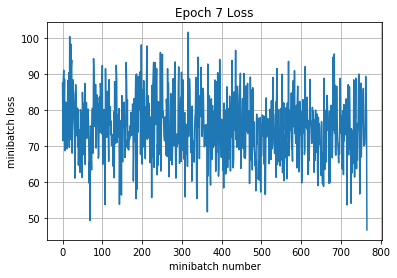

Iteration 5400: with minibatch training loss = 0.979 and accuracy of 0.66
Iteration 5500: with minibatch training loss = 1.2 and accuracy of 0.59
Iteration 5600: with minibatch training loss = 0.89 and accuracy of 0.72
Iteration 5700: with minibatch training loss = 0.909 and accuracy of 0.7
Iteration 5800: with minibatch training loss = 1.14 and accuracy of 0.62
Iteration 5900: with minibatch training loss = 1.29 and accuracy of 0.56
Iteration 6000: with minibatch training loss = 1.07 and accuracy of 0.61
Iteration 6100: with minibatch training loss = 1.26 and accuracy of 0.59
Epoch 8, Overall loss = 1.14 and accuracy of 0.595


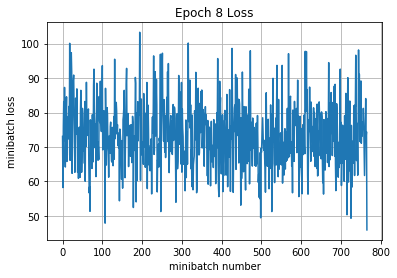

Iteration 6200: with minibatch training loss = 1.08 and accuracy of 0.59
Iteration 6300: with minibatch training loss = 1.02 and accuracy of 0.66
Iteration 6400: with minibatch training loss = 1.18 and accuracy of 0.53
Iteration 6500: with minibatch training loss = 0.949 and accuracy of 0.58
Iteration 6600: with minibatch training loss = 1.16 and accuracy of 0.59
Iteration 6700: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 6800: with minibatch training loss = 0.954 and accuracy of 0.66
Epoch 9, Overall loss = 1.1 and accuracy of 0.608


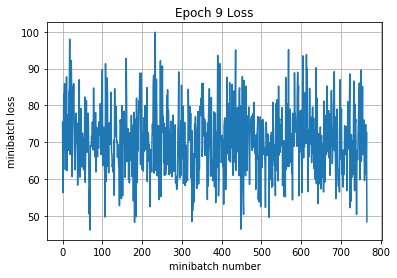

Iteration 6900: with minibatch training loss = 0.995 and accuracy of 0.66
Iteration 7000: with minibatch training loss = 0.929 and accuracy of 0.66
Iteration 7100: with minibatch training loss = 1.09 and accuracy of 0.58
Iteration 7200: with minibatch training loss = 0.849 and accuracy of 0.7
Iteration 7300: with minibatch training loss = 1.18 and accuracy of 0.56
Iteration 7400: with minibatch training loss = 0.953 and accuracy of 0.59
Iteration 7500: with minibatch training loss = 1.06 and accuracy of 0.66
Iteration 7600: with minibatch training loss = 0.983 and accuracy of 0.62
Epoch 10, Overall loss = 1.05 and accuracy of 0.626


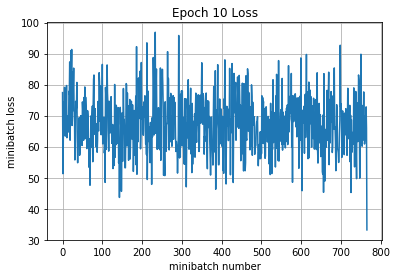

4985.301273584366
Validation
Epoch 1, Overall loss = 1.1 and accuracy of 0.595
Training
Epoch 1, Overall loss = 1.01 and accuracy of 0.635
Validation
Epoch 1, Overall loss = 1.1 and accuracy of 0.595
Test
Epoch 1, Overall loss = 1.14 and accuracy of 0.589


(1.1386481319427491, 0.58909999999999996)

In [85]:
###################################################################################
#      inception model v3 test
###################################################################################

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = inception_model3(X,y,is_training)
optimizer = tf.train.AdamOptimizer(1e-3)
total_loss = tf.losses.softmax_cross_entropy(logits =y_out,onehot_labels=tf.one_hot(y,10))
mean_loss =  tf.reduce_mean(total_loss)
train_step = optimizer.minimize(mean_loss)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())
start_time = time.time()
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
end_time = time.time()
print (end_time-start_time)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Training
Iteration 0: with minibatch training loss = 25.2 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.99 and accuracy of 0.27
Iteration 200: with minibatch training loss = 2.05 and accuracy of 0.2
Iteration 300: with minibatch training loss = 1.97 and accuracy of 0.17
Iteration 400: with minibatch training loss = 1.97 and accuracy of 0.19
Iteration 500: with minibatch training loss = 2.02 and accuracy of 0.3
Iteration 600: with minibatch training loss = 1.78 and accuracy of 0.45
Iteration 700: with minibatch training loss = 1.87 and accuracy of 0.31
Epoch 1, Overall loss = 3.03 and accuracy of 0.271


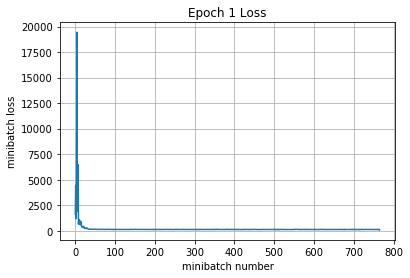

Iteration 800: with minibatch training loss = 2.01 and accuracy of 0.3
Iteration 900: with minibatch training loss = 1.83 and accuracy of 0.36
Iteration 1000: with minibatch training loss = 1.89 and accuracy of 0.31
Iteration 1100: with minibatch training loss = 1.87 and accuracy of 0.36
Iteration 1200: with minibatch training loss = 1.92 and accuracy of 0.28
Iteration 1300: with minibatch training loss = 1.87 and accuracy of 0.36
Iteration 1400: with minibatch training loss = 1.88 and accuracy of 0.33
Iteration 1500: with minibatch training loss = 1.85 and accuracy of 0.36
Epoch 2, Overall loss = 1.92 and accuracy of 0.317


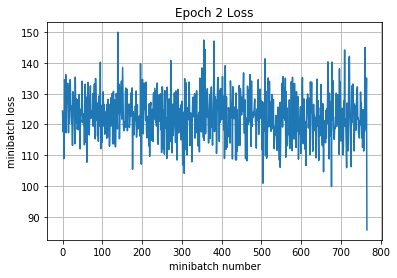

Iteration 1600: with minibatch training loss = 1.85 and accuracy of 0.36
Iteration 1700: with minibatch training loss = 1.77 and accuracy of 0.39
Iteration 1800: with minibatch training loss = 1.98 and accuracy of 0.23
Iteration 1900: with minibatch training loss = 1.87 and accuracy of 0.31
Iteration 2000: with minibatch training loss = 2.05 and accuracy of 0.27
Iteration 2100: with minibatch training loss = 1.81 and accuracy of 0.33
Iteration 2200: with minibatch training loss = 2.13 and accuracy of 0.2
Epoch 3, Overall loss = 1.9 and accuracy of 0.33


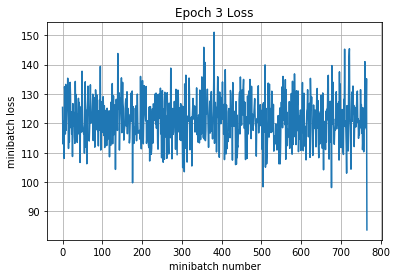

Iteration 2300: with minibatch training loss = 1.8 and accuracy of 0.44
Iteration 2400: with minibatch training loss = 2.04 and accuracy of 0.36
Iteration 2500: with minibatch training loss = 1.82 and accuracy of 0.3
Iteration 2600: with minibatch training loss = 1.66 and accuracy of 0.36
Iteration 2700: with minibatch training loss = 2.09 and accuracy of 0.28
Iteration 2800: with minibatch training loss = 1.72 and accuracy of 0.38
Iteration 2900: with minibatch training loss = 1.99 and accuracy of 0.31
Iteration 3000: with minibatch training loss = 1.82 and accuracy of 0.34
Epoch 4, Overall loss = 1.89 and accuracy of 0.333


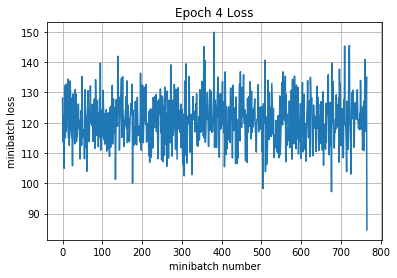

Iteration 3100: with minibatch training loss = 1.89 and accuracy of 0.33
Iteration 3200: with minibatch training loss = 1.92 and accuracy of 0.3
Iteration 3300: with minibatch training loss = 1.85 and accuracy of 0.27
Iteration 3400: with minibatch training loss = 1.83 and accuracy of 0.36
Iteration 3500: with minibatch training loss = 2 and accuracy of 0.41
Iteration 3600: with minibatch training loss = 1.86 and accuracy of 0.33
Iteration 3700: with minibatch training loss = 1.84 and accuracy of 0.33
Iteration 3800: with minibatch training loss = 2.01 and accuracy of 0.34
Epoch 5, Overall loss = 1.89 and accuracy of 0.333


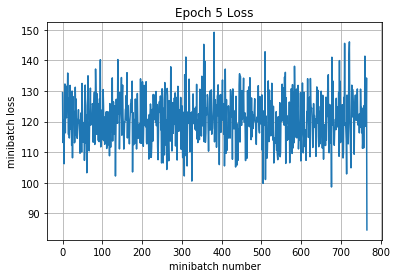

Iteration 3900: with minibatch training loss = 2.04 and accuracy of 0.31
Iteration 4000: with minibatch training loss = 1.94 and accuracy of 0.36
Iteration 4100: with minibatch training loss = 1.89 and accuracy of 0.31
Iteration 4200: with minibatch training loss = 2.02 and accuracy of 0.28
Iteration 4300: with minibatch training loss = 1.83 and accuracy of 0.41
Iteration 4400: with minibatch training loss = 2.01 and accuracy of 0.3
Iteration 4500: with minibatch training loss = 1.72 and accuracy of 0.36
Epoch 6, Overall loss = 1.89 and accuracy of 0.334


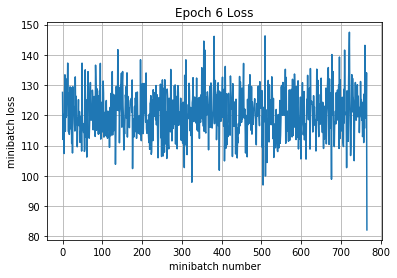

Iteration 4600: with minibatch training loss = 1.68 and accuracy of 0.47
Iteration 4700: with minibatch training loss = 1.81 and accuracy of 0.36
Iteration 4800: with minibatch training loss = 1.83 and accuracy of 0.33
Iteration 4900: with minibatch training loss = 1.81 and accuracy of 0.28
Iteration 5000: with minibatch training loss = 1.92 and accuracy of 0.25
Iteration 5100: with minibatch training loss = 1.54 and accuracy of 0.41
Iteration 5200: with minibatch training loss = 1.86 and accuracy of 0.31
Iteration 5300: with minibatch training loss = 1.85 and accuracy of 0.42
Epoch 7, Overall loss = 1.89 and accuracy of 0.332


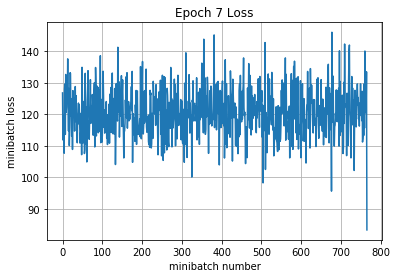

Iteration 5400: with minibatch training loss = 1.82 and accuracy of 0.33
Iteration 5500: with minibatch training loss = 1.81 and accuracy of 0.34
Iteration 5600: with minibatch training loss = 1.99 and accuracy of 0.28
Iteration 5700: with minibatch training loss = 1.76 and accuracy of 0.38
Iteration 5800: with minibatch training loss = 1.83 and accuracy of 0.39
Iteration 5900: with minibatch training loss = 1.76 and accuracy of 0.45
Iteration 6000: with minibatch training loss = 1.86 and accuracy of 0.33
Iteration 6100: with minibatch training loss = 1.9 and accuracy of 0.3
Epoch 8, Overall loss = 1.89 and accuracy of 0.33


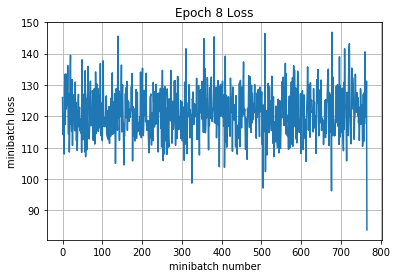

Iteration 6200: with minibatch training loss = 1.88 and accuracy of 0.34
Iteration 6300: with minibatch training loss = 1.9 and accuracy of 0.36
Iteration 6400: with minibatch training loss = 2.24 and accuracy of 0.31
Iteration 6500: with minibatch training loss = 1.88 and accuracy of 0.36
Iteration 6600: with minibatch training loss = 2.04 and accuracy of 0.27
Iteration 6700: with minibatch training loss = 1.84 and accuracy of 0.36
Iteration 6800: with minibatch training loss = 1.97 and accuracy of 0.3
Epoch 9, Overall loss = 1.9 and accuracy of 0.326


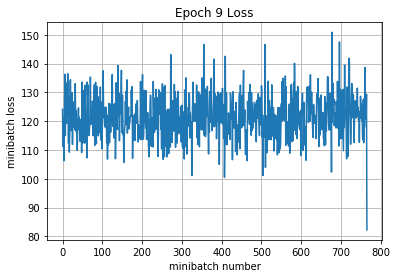

Iteration 6900: with minibatch training loss = 2.05 and accuracy of 0.2
Iteration 7000: with minibatch training loss = 1.83 and accuracy of 0.31
Iteration 7100: with minibatch training loss = 1.91 and accuracy of 0.36
Iteration 7200: with minibatch training loss = 1.66 and accuracy of 0.47
Iteration 7300: with minibatch training loss = 1.97 and accuracy of 0.28
Iteration 7400: with minibatch training loss = 1.85 and accuracy of 0.3
Iteration 7500: with minibatch training loss = 1.8 and accuracy of 0.41
Iteration 7600: with minibatch training loss = 1.72 and accuracy of 0.34
Epoch 10, Overall loss = 1.91 and accuracy of 0.322


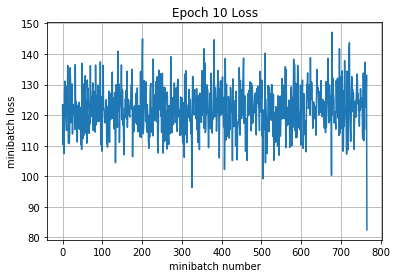

23092.092879772186
Validation
Epoch 1, Overall loss = 1.93 and accuracy of 0.311
Training
Epoch 1, Overall loss = 1.91 and accuracy of 0.315
Validation
Epoch 1, Overall loss = 1.93 and accuracy of 0.311
Test
Epoch 1, Overall loss = 1.9 and accuracy of 0.323


(1.9027338600158692, 0.32250000000000001)

In [6]:
###################################################################################
#      Network In Network test
###################################################################################

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out =NIN(X,y,is_training)
optimizer = tf.train.AdamOptimizer(1e-3)
total_loss = tf.losses.softmax_cross_entropy(logits =y_out,onehot_labels=tf.one_hot(y,10))
mean_loss =  tf.reduce_mean(total_loss)
train_step = optimizer.minimize(mean_loss)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())
start_time = time.time()
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
end_time = time.time()
print (end_time-start_time)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

In [8]:
###################################################################################
#      residual net test
###################################################################################

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = residual(X,y,is_training)
optimizer = tf.train.AdamOptimizer(1e-3)
total_loss = tf.losses.softmax_cross_entropy(logits =y_out,onehot_labels=tf.one_hot(y,10))
mean_loss =  tf.reduce_mean(total_loss)
train_step = optimizer.minimize(mean_loss)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())
start_time = time.time()
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
end_time = time.time()
print (end_time-start_time)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Training
Iteration 0: with minibatch training loss = 93.1 and accuracy of 0.078


KeyboardInterrupt: 

In [75]:
# GPU Test.
tf.reset_default_graph()
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

InvalidArgumentError: Cannot assign a device to node 'b': Could not satisfy explicit device specification '/device:GPU:0' because no devices matching that specification are registered in this process; available devices: /job:localhost/replica:0/task:0/cpu:0
	 [[Node: b = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [3,2] values: [1 2][3]...>, _device="/device:GPU:0"]()]]

Caused by op 'b', defined at:
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-d78604453c0b>", line 5, in <module>
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/media/kim/00aa6e8b-6a85-4ac5-9c45-2af329868dff/kim/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device to node 'b': Could not satisfy explicit device specification '/device:GPU:0' because no devices matching that specification are registered in this process; available devices: /job:localhost/replica:0/task:0/cpu:0
	 [[Node: b = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [3,2] values: [1 2][3]...>, _device="/device:GPU:0"]()]]
